In [2]:
import pandas as pd
from ast import literal_eval
import numpy as np
np.seterr(all="raise")

today = "2019-11-06"

df = pd.read_parquet(f"out/{today}-2d-test.parquet")
df["total_params1"] = df["shape1[0]"] * df["shape1[1]"]
df["total_params2"] = df["shape2[0]"] * df["shape2[1]"]
print(len(df))
df.tail()

73023


,shape1[0],shape2[0],shape1[1],shape2[1],mode,seed,fft_time,direct_time,total_params1,total_params2
73018,74,25,45,50,full,24339,0.000487,0.191245,3330,1250
73019,74,25,45,50,same,24339,0.000532,0.080625,3330,1250
73020,12,8,95,8,valid,24340,0.000313,0.000654,1140,64
73021,12,8,95,8,full,24340,0.000264,0.002489,1140,64
73022,12,8,95,8,same,24340,0.000285,0.001687,1140,64


In [3]:
from functools import lru_cache

def _prod(iterable):
    r = 1
    for it in iterable:
        r *= it
    return r
    
sum_builtin = sum

# def _get_constant(mode, x_ndim, x_size, h_size):
#     if mode == 'full':
#         big_O_constant = 10963.92823819 if x_ndim == 1 else 8899.1104874
#     elif mode == 'same':
#         oneD_big_O = {True: 7183.41306773, False: 856.78174111}
#         big_O_constant = oneD_big_O[h_size <= x_size] if x_ndim == 1 \
#                                                       else 34519.21021589
#     elif mode == 'valid':
#         big_O_constant = 41954.28006344 if x_ndim == 1 else 66453.24316434
#     else:
#         raise ValueError('mode is invalid')
#     return big_O_constant

@lru_cache()
def _get_constant(mode, x_ndim, x_size, h_size):
    df = pd.read_csv("constants.csv")
    idx = (df["ndim"] == 2) & (df["mode"] == mode)
    assert idx.sum() == 1
    return df[idx]["constant"].values.item()

In [4]:
def _fftconv_faster(x_shape, h_shape, mode):
    """
    See if using fftconvolve or convolve is faster. The value returned (a
    boolean) depends on the sizes and shapes of the input values.
    The big O ratios were found to hold to different machines, which makes
    sense as it's the ratio that matters (the effective speed of the computer
    is found in both big O constants). Regardless, this had been tuned on an
    early 2015 MacBook Pro with 8GB RAM and an Intel i5 processor.
    """
    x_size = _prod(x_shape)
    x_ndim = len(x_shape)
    h_size = _prod(h_shape)
    h_ndim = len(h_shape)
    if mode == 'full':
        out_shape = [n + k - 1 for n, k in zip(x_shape, h_shape)]
    elif mode == 'same':
        out_shape = x_shape
    elif mode == 'valid':
        out_shape = [n - k + 1 for n, k in zip(x_shape, h_shape)]
    else:
        raise ValueError('mode is invalid')
    out_shape = [o if o > 0 else -o + 2 for o in out_shape]

    # see whether the Fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    direct_time = min(x_size, h_size) * _prod(out_shape)
    fft_time = sum_builtin(n * np.log(n) for n in (x_shape + h_shape +
                                               tuple(out_shape)))
    big_O_constant = _get_constant(mode, x_ndim, x_size, h_size)
    return "fft" if big_O_constant * fft_time < direct_time else "direct"

def estimate_faster_method(row):
    x_shape = (row["shape1[0]"], row["shape1[1]"])
    h_shape = (row["shape2[0]"], row["shape2[1]"])
    mode = row["mode"]
    return _fftconv_faster(x_shape, h_shape, mode)

In [5]:
fft_faster = df["fft_time"] < df["direct_time"]
df["faster"] = ""
df.loc[fft_faster, "faster"] = "fft"
df.loc[~fft_faster, "faster"] = "direct"

df["faster_est"] = df.apply(estimate_faster_method, axis=1)

acc = (df.faster == df.faster_est).sum() / len(df)
print(f"Predicted fastest method {100 * acc:0.2f}% of the time")

Predicted fastest method 91.43% of the time


**Goal for accuracy on predicting fastest**: >90% -- that's the performance seen with code from SciPy 1.3 (after uncommenting `_get_constant` function above)

In [6]:
wrong_idx = df.faster != df.faster_est
wrong =  df[wrong_idx].copy()
wrong["ratio"] = wrong.fft_time / wrong.direct_time
idx = wrong.ratio < 1
wrong.loc[idx, "ratio"] = 1 / wrong.loc[idx, "ratio"]

vals = wrong[["mode", "shape1[0]", "shape1[1]", "shape2[0]", "shape2[1]", "ratio", "direct_time", "fft_time"]].copy()
vals.sort_values(by="direct_time", inplace=True)
vals.tail(n=10)

,mode,shape1[0],shape1[1],shape2[0],shape2[1],ratio,direct_time,fft_time
72719,same,3,17,61,122,10.158508,0.004156,0.000409
21086,same,5,10,66,132,8.975500,0.004280,0.000477
28535,same,6,9,63,126,9.935313,0.004467,0.000450
14102,same,15,4,57,114,6.180231,0.004472,0.000724
43853,same,4,16,62,124,10.268694,0.004911,0.000478
29354,same,5,11,64,128,9.829465,0.004947,0.000503
21557,same,10,5,66,132,9.453436,0.004986,0.000527
14846,same,7,9,64,128,11.071646,0.005195,0.000469
9092,same,22,3,64,128,11.554066,0.006165,0.000534
9446,same,3,23,69,138,13.091188,0.007119,0.000544


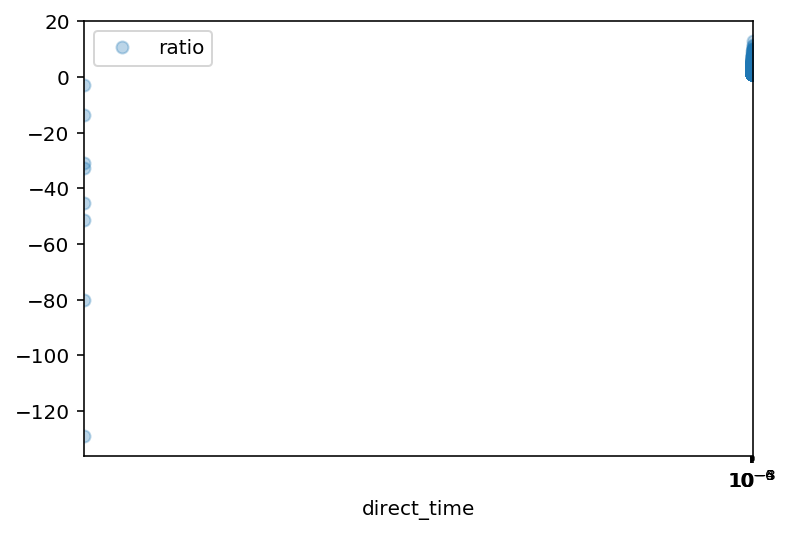

In [7]:
ax = vals.plot(x="direct_time", y="ratio", style="o", alpha=0.3)
ax.set_xscale("log")

In [8]:
vals.direct_time.min()

-0.03404641151428223

(1, 10)

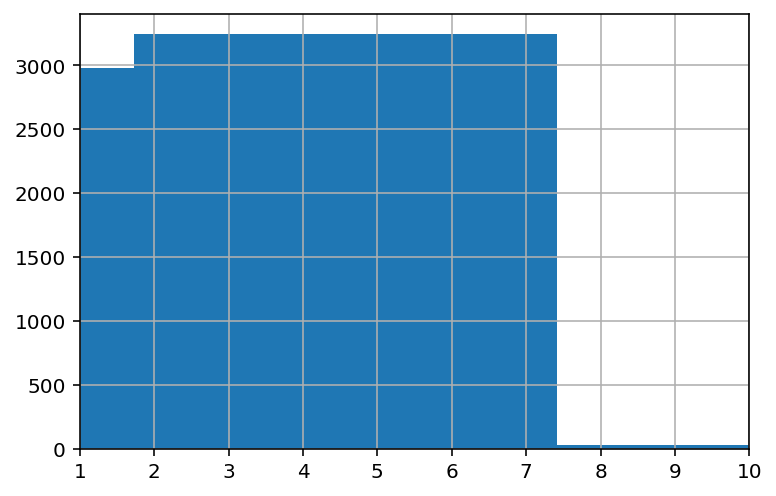

In [9]:
ax = wrong.ratio.hist(bins=25)
ax.set_xlim(1, 10)

**Goal for this histogram:** `ratio.max() < 5` approximately. That's the performance with SciPy 1.3 (again, after un-commenting `_get_constants` above).

In [10]:
(wrong.ratio <= 5).sum() / len(wrong)

0.9819373401534527